<a href="https://colab.research.google.com/github/PozzOver13/learning/blob/main/bayesian_modeling/20250305_bayesian_hierachical_models_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Hierarchical Models

## Definizione

I modelli gerarchici bayesiani (Bayesian Hierarchical Models, BHM) sono una classe di modelli statistici che combinano la modellazione gerarchica con l'approccio bayesiano per catturare la struttura multi-livello dei dati e incorporare informazioni a priori.

## Caratteristiche principali
**Struttura Gerarchica**  
* I parametri del modello sono organizzati in più livelli, riflettendo la struttura naturale dei dati (es. individui all'interno di gruppi).
* Le osservazioni condividono parametri comuni, ma ogni sottogruppo può avere caratteristiche specifiche.  

**Approccio Bayesiano**  
* Si utilizza la Regola di Bayes per aggiornare le credenze sui parametri alla luce dei dati osservati.
* Si definiscono distribuzioni a priori per i parametri, che vengono aggiornate in distribuzioni a posteriori.

**Pooling dell'Informazione**

* Complete Pooling: si assume che tutti i gruppi condividano lo stesso parametro (sovrastima la similarità).
* No Pooling: ogni gruppo ha un parametro indipendente (sottostima la similarità).
* Partial Pooling (Shrinking): i parametri di gruppo sono parzialmente vincolati da un livello superiore, ottenendo un compromesso tra complete e no pooling.

## Vantaggi e Svantaggi  
✅ Stime più robuste quando i dati per alcuni gruppi sono scarsi.  
✅ Permette di incorporare conoscenza preesistente tramite distribuzioni a priori.  
✅ Modella naturalmente la variabilità tra gruppi.  

❌ Computazionalmente intensivo (richiede metodi MCMC o VI).  
❌ Sensibile alla scelta della distribuzione a priori.

## References

https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/multilevel_modeling.html

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import xarray as xr
import arviz as az

In [2]:


# Impostiamo il seed per replicabilità
np.random.seed(42)

# Definizione delle regioni
regioni = ["Regione 1", "Regione 2"]

# Definizione delle classi energetiche ordinate
classi_energetiche = ["A", "B", "C", "D", "E", "F", "G"]

# Numero di perizie simulate per regione
n_perizie = 500

# Media globale dei prezzi
mu_globale = 1500  # €/mq

# Definiamo effetti specifici per classe energetica (espressi in €/mq rispetto alla media)
effetti_classe = {
    "A": 200,  # Prezzo più alto
    "B": 150,
    "C": 100,
    "D": 50,
    "E": -50,
    "F": -100,
    "G": -200  # Prezzo più basso
}

# Generiamo un dataset con le perizie
dati = []
for regione in regioni:
    # Definiamo una media regionale con una piccola variazione
    mu_regione = mu_globale + np.random.normal(0, 200)  # Media regionale con variazione casuale

    for _ in range(n_perizie):
        classe = np.random.choice(classi_energetiche, p=[0.1, 0.15, 0.2, 0.2, 0.15, 0.1, 0.1])  # Distribuzione casuale

        # Prezzo determinato da media globale, variazione regionale e classe energetica
        prezzo_mq = mu_regione + effetti_classe[classe] + np.random.normal(0, 50)  # Rumore
        dati.append([regione, classe, prezzo_mq])

# Creiamo il DataFrame
df = pd.DataFrame(dati, columns=["Regione", "ClasseEnergetica", "Prezzo_mq"])

# Controlliamo i primi dati generati
df.head()


,Regione,ClasseEnergetica,Prezzo_mq
0,Regione 1,E,1542.429616
1,Regione 1,D,1637.635162
2,Regione 1,A,1787.635983
3,Regione 1,F,1578.303471
4,Regione 1,A,1837.714567


In [3]:
# Statistiche descrittive
df.groupby(["Regione"])["Prezzo_mq"].median()

,Prezzo_mq
Regione,
Regione 1,1654.850765
Regione 2,1472.145890


In [4]:
# Statistiche descrittive
df.groupby(["Regione", "ClasseEnergetica"])["Prezzo_mq"].median()

Regione    ClasseEnergetica
Regione 1  A                   1796.607283
           B                   1747.705167
           C                   1700.393023
           D                   1648.417174
           E                   1558.665546
           F                   1510.294640
           G                   1394.673481
Regione 2  A                   1613.261972
           B                   1571.013444
           C                   1520.959090
           D                   1478.350916
           E                   1367.628243
           F                   1342.740568
           G                   1223.975271
Name: Prezzo_mq, dtype: float64

In [5]:
# Statistiche descrittive
df.groupby(["Regione", "ClasseEnergetica"])["Prezzo_mq"].describe()

count         mean        std          min  \
Regione   ClasseEnergetica                                               
Regione 1 A                  56.0  1796.063246  46.950074  1637.279464   
          B                  77.0  1744.627386  44.607319  1614.498498   
          C                  89.0  1701.806369  52.011032  1595.246360   
          D                 103.0  1647.074476  45.666484  1548.085701   
          E                  65.0  1560.463761  50.472718  1457.299119   
          F                  54.0  1504.296667  48.337847  1397.436604   
          G                  56.0  1399.101590  49.374086  1288.786065   
Regione 2 A                  46.0  1616.730066  43.774149  1528.199685   
          B                  67.0  1567.816880  50.115731  1446.173756   
          C                  92.0  1522.861762  47.932415  1378.046128   
          D                 100.0  1475.174332  50.374650  1360.004902   
          E                  85.0  1366.340273  59.719563  1198.419247   
          F                  61.0  1334.896703  41.873568  1208.610128   
          G                  49.0  1219.316293  39.502874  1144.369345   

                                    25%          50%          75%          max  
Regione   ClasseEnergetica                                                      
Regione 1 A                 1763.875833  1796.607283  1814.962060  1922.504936  
          B                 1717.473474  1747.705167  1776.470833  1842.631556  
          C                 1666.211643  1700.393023  1739.969122  1803.962194  
          D                 1616.713697  1648.417174  1680.555763  1729.002162  
          E                 1522.817773  1558.665546  1593.424818  1741.979405  
          F                 1471.179868  1510.294640  1538.368485  1612.877473  
          G                 1373.360754  1394.673481  1424.102141  1528.010821  
Regione 2 A                 1585.879030  1613.261972  1644.573761  1713.058694  
          B                 1536.436918  1571.013444  1589.991003  1705.618806  
          C                 1487.287267  1520.959090  1552.533606  1656.836406  
          D                 1437.481350  1478.350916  1510.737342  1583.594469  
          E                 1332.335051  1367.628243  1400.957203  1520.710206  
          F                 1312.712428  1342.740568  1358.640217  1413.438340  
          G                 1188.415324  1223.975271  1243.186779  1292.330423

In [12]:
df["log_prezzo_mq"] = log_prezzo_mq = np.log(df.Prezzo_mq + 0.1).values
df = df.sort_values(["Regione", "ClasseEnergetica"], ascending=[True, False])
df.ClasseEnergetica = df.ClasseEnergetica.map(str.strip)

ape, mn_ape = df.ClasseEnergetica.factorize()
df["ape_num"] = ape

regione_num, mn_regione = df.ClasseEnergetica.factorize()
df["regione_num"] = regione_num


In [18]:
mn_ape.to_list()

['G', 'F', 'E', 'D', 'C', 'B', 'A']

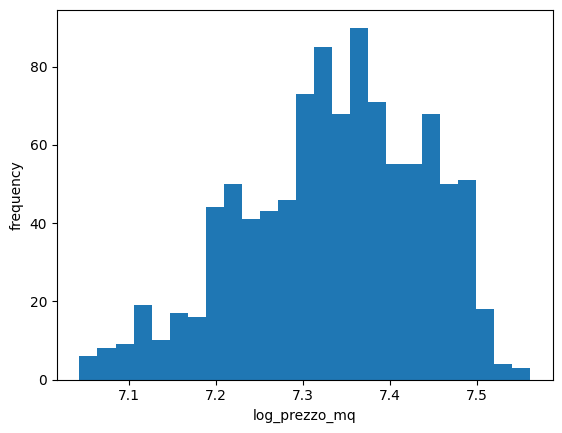

In [8]:
df.log_prezzo_mq.hist(bins=25, grid=False)
plt.xlabel("log_prezzo_mq")
plt.ylabel("frequency");

## Complete Pooling

In [9]:
with pm.Model() as pooled_model:
  floor_ind = pm.MutableData("ape_ind", ape, dims="obs_id")
  alpha = pm.Normal("alpha", 0, sigma=10)
  beta = pm.Normal("beta", mu=0, sigma=10)
  sigma = pm.Exponential("sigma", 5)

  theta = alpha + beta * floor_ind

  y = pm.Normal("y", theta, sigma=sigma, observed=log_prezzo_mq, dims="obs_id")

/usr/local/lib/python3.11/dist-packages/pymc/data.py:321: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


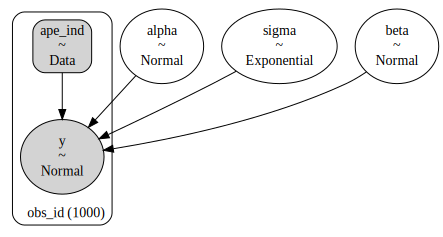

In [10]:
pm.model_to_graphviz(pooled_model)

In [13]:
RANDOM_SEED = 13
with pooled_model:
    prior_checks = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

In [21]:
mn_ape.to_list()

['G', 'F', 'E', 'D', 'C', 'B', 'A']

In [23]:
prior

<xarray.Dataset> Size: 16kB
Dimensions:  (draw: 500)
Coordinates:
  * draw     (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
Data variables:
    alpha    (draw) float64 4kB 5.153 -21.54 7.03 ... -10.3 -0.2397 -12.67
    beta     (draw) float64 4kB -3.369 14.35 1.175 6.436 ... 12.88 -2.212 -2.146
    sigma    (draw) float64 4kB 0.1295 0.05298 0.5507 ... 0.2409 0.01082 0.2134
Attributes:
    created_at:                 2025-03-05T17:35:11.110767+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.20.1

In [25]:
prior = prior_checks.prior.squeeze(drop=True)
(
    xr.concat((prior["alpha"], prior["alpha"] + prior["beta"]), dim="ape_labels")
    .rename("log_prezzo_mq")
    # .assign_coords(ape_labels=mn_ape.to_list())
    # .plot.scatter(x="ape_labels", y="log_prezzo_mq", edgecolors="none")
)

<xarray.DataArray 'log_prezzo_mq' (ape_labels: 2, draw: 500)> Size: 8kB
array([[ 5.15318463e+00, -2.15386236e+01,  7.02988930e+00,
        -3.58818389e+00,  7.30693989e+00, -1.19593196e+01,
         1.32918855e+00, -4.08196892e-01,  1.13117295e+01,
        -3.13713447e+00, -7.41202823e+00, -7.08365700e+00,
        -3.80103509e+00, -6.10258622e+00, -3.74086069e+00,
        -2.87651835e-01, -3.90089146e-01,  4.16509859e+00,
         1.78494579e+00, -1.37469026e+01, -3.43489549e+00,
         2.38220693e+00,  1.74122771e+00,  7.16980423e+00,
         1.44404731e+01, -7.80057689e+00, -1.03270761e+00,
         3.04242356e+00, -4.68407571e+00,  3.19080542e+00,
        -6.64727404e+00,  1.21789350e+00,  1.43953218e+01,
         6.13849704e+00, -3.09945856e+00,  1.39841750e+01,
        -2.58110599e+01,  2.39671724e+00, -3.97941358e-03,
        -8.54377791e+00,  2.61965670e+00,  3.35038125e+00,
        -8.37584832e+00, -1.03017869e+01,  8.04085039e+00,
         8.46705597e+00,  5.42082181e+00, -7.23571025e+00,
         1.44051820e+00, -1.26685150e+01, -9.28843271e+00,
         1.01981738e+01, -1.86028261e+00,  2.05886519e+00,
        -7.98688621e+00,  7.02001243e+00, -1.72288820e+01,
        -8.07754058e+00,  1.43267437e+01, -1.31545314e+00,
...
        -1.18752919e+01,  2.33519611e+01, -6.48175979e-01,
        -5.20597272e+00, -5.38837327e+00, -2.82857954e+01,
         4.34631319e+01,  6.19607730e+00,  5.83797338e+00,
         9.38897902e+00, -8.10743444e+00, -2.01868228e+00,
         6.14984021e+00, -4.68061476e+00,  1.20370297e+01,
        -1.78749108e+01, -1.12027570e+00,  3.96091747e+00,
         1.30061432e+01,  1.36298542e+01, -3.20593183e+01,
         7.47885354e+00,  2.10066044e+01,  3.94629459e+01,
        -2.46128062e+01,  1.48526635e+00,  1.85086195e+01,
        -1.11707457e+01, -2.13937461e+00, -3.23121346e-01,
        -1.49614799e+01,  2.49589976e+01,  9.58276861e+00,
         1.11597714e+01, -2.61209769e+01,  1.23340715e+01,
        -1.58018703e+00, -1.51535567e+00,  3.16337829e+00,
         1.74871386e+00,  8.06390245e+00,  3.48692468e+01,
         1.57870667e+01,  7.73920239e+00,  3.74496854e+01,
        -1.25687042e+01, -7.80906209e+00, -3.08340140e+01,
        -1.88832392e+01,  5.77724419e+00, -1.55022358e+01,
         5.73363322e+00, -6.56917552e+00, -1.49403912e+00,
         1.32381901e+01,  1.95366399e+01,  2.57717232e+00,
        -2.45198110e+00, -1.48118100e+01]])
Coordinates:
  * draw     (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
Dimensions without coordinates: ape_labels

In [26]:
with pooled_model:
    pooled_trace = pm.sample(random_seed=RANDOM_SEED)

Output()

In [28]:
az.summary(pooled_trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,7.33,0.01,7.31,7.34,0.0,0.0,793.78,1119.90,1.0
beta,0.00,0.00,-0.00,0.01,0.0,0.0,795.93,871.80,1.0
sigma,0.10,0.00,0.10,0.11,0.0,0.0,1292.22,1075.16,1.0


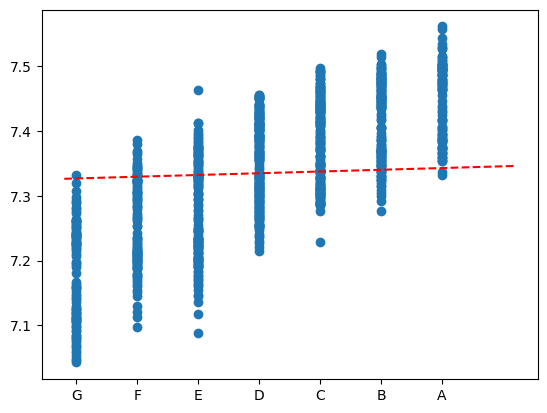

In [31]:
post_mean = pooled_trace.posterior.mean(dim=("chain", "draw"))

plt.scatter(df.ClasseEnergetica, np.log(df.Prezzo_mq + 0.1))
xvals = xr.DataArray(np.linspace(-0.2, 7.2))
plt.plot(xvals, post_mean["beta"] * xvals + post_mean["alpha"], "r--");

## Unpooled

In [34]:
coords = {"ape": mn_ape}

with pm.Model(coords=coords) as unpooled_model:
    floor_ind = pm.MutableData("ape_ind", ape, dims="obs_id")

    alpha = pm.Normal("alpha", 0, sigma=10, dims="ape")
    beta = pm.Normal("beta", 0, sigma=10)
    sigma = pm.Exponential("sigma", 1)

    theta = alpha[ape] + beta * floor_ind

    y = pm.Normal("y", theta, sigma=sigma, observed=log_prezzo_mq, dims="obs_id")

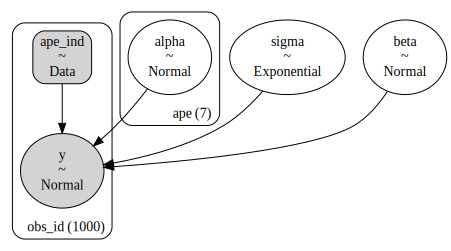

In [35]:
pm.model_to_graphviz(unpooled_model)

In [36]:
with unpooled_model:
    unpooled_trace = pm.sample(random_seed=RANDOM_SEED)

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [45]:
az.summary(unpooled_trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[G],7.18,0.01,7.17,7.19,0.00,0.00,245.10,253.05,1.01
alpha[F],6.03,1.09,4.27,7.95,0.57,0.44,4.11,48.25,1.44
alpha[E],4.84,2.18,1.20,8.57,1.13,0.89,4.12,48.98,1.44
alpha[D],3.70,3.27,-1.75,9.29,1.70,1.31,4.11,48.98,1.44
alpha[C],2.51,4.36,-4.75,9.97,2.27,1.75,4.12,48.98,1.44
alpha[B],1.32,5.45,-7.75,10.64,2.84,2.19,4.11,48.98,1.44
alpha[A],0.13,6.54,-10.75,11.32,3.40,2.63,4.12,48.98,1.44
beta,1.22,1.09,-0.65,3.03,0.57,0.44,4.11,48.98,1.44
sigma,0.07,0.00,0.06,0.07,0.00,0.00,228.15,351.41,1.01


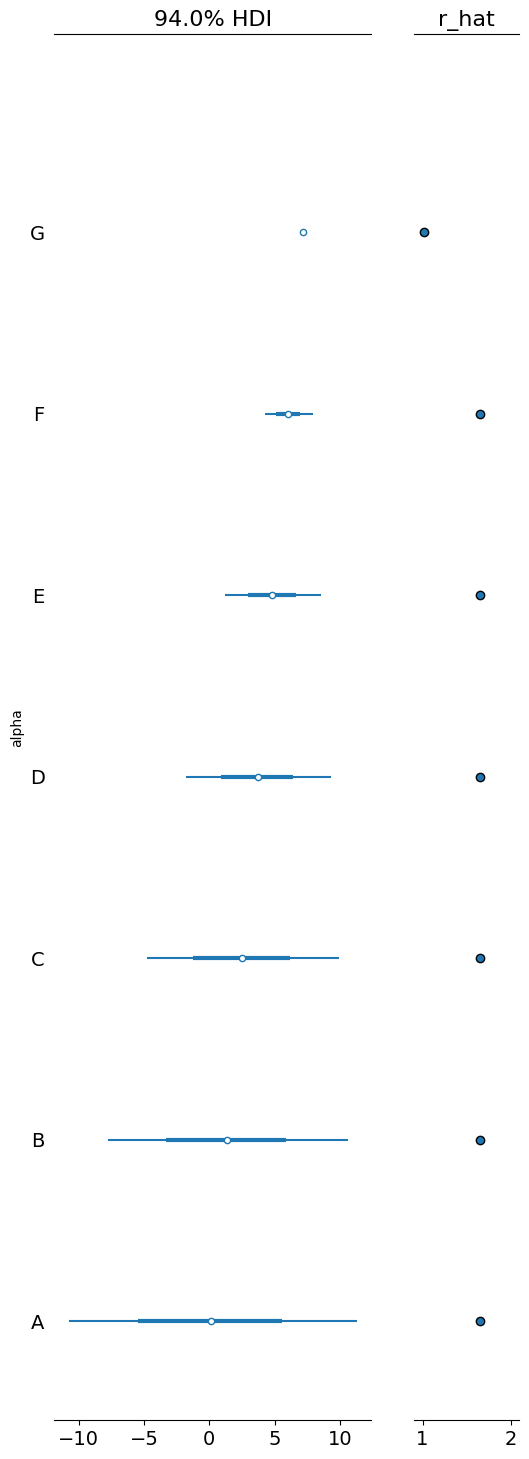

In [37]:
ax = az.plot_forest(
    unpooled_trace,
    var_names=["alpha"],
    r_hat=True,
    combined=True,
    figsize=(6, 18),
    labeller=az.labels.NoVarLabeller(),
)
ax[0].set_ylabel("alpha");

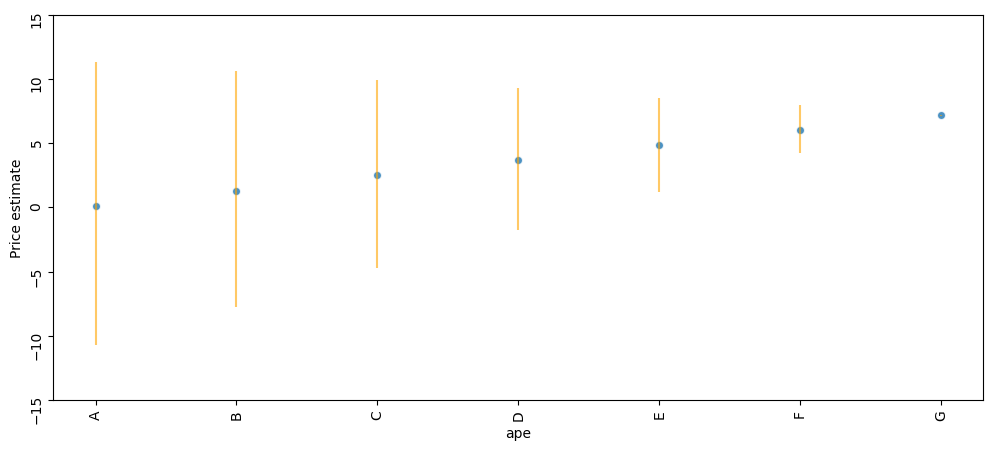

In [49]:
unpooled_means = unpooled_trace.posterior.mean(dim=("chain", "draw"))
unpooled_hdi = az.hdi(unpooled_trace)

unpooled_means_iter = unpooled_means.sortby("alpha")
unpooled_hdi_iter = unpooled_hdi.sortby(unpooled_means_iter.alpha)

_, ax = plt.subplots(figsize=(12, 5))
xticks = np.arange(0, 7, 1)
unpooled_means_iter.plot.scatter(x="ape", y="alpha", ax=ax, alpha=0.8)
ax.vlines(
   np.arange(mn_ape.size),
   unpooled_hdi_iter.alpha.sel(hdi="lower"),
   unpooled_hdi_iter.alpha.sel(hdi="higher"),
   color="orange",
   alpha=0.6,
)
ax.set(ylabel="Price estimate", ylim=(-15, 15))
ax.set_xticks(xticks)
ax.set_xticklabels(unpooled_means_iter.ape.values[xticks])
ax.tick_params(rotation=90);

## Multilevel and hierarchical models